# PINN for Projectile Motion in Gravitational Field

This notebook demonstrates how to use Physics-Informed Neural Networks (PINNs) to model the vertical motion (y-direction) of a projectile under constant gravity. We define the governing ordinary differential equation (ODE), the initial conditions, and implement a PyTorch model trained with an ODE residual loss plus initial-condition losses.

## Governing equations (y-direction)

We consider the motion of a ball in the vertical (y) direction under constant gravitational acceleration g. The governing ODE is:

$$y''(t) = -g,$$

with initial conditions at time $t=0$:

$$y(0) = h_0, \; y'(0) = v_0,$$

The analytical solution is:

$$y(t) = h_0 + v_0 t - \frac{1}{2} g t^2.$$

In the PINN approach we train a neural network approximator $\hat{y}(t;\theta)$ and enforce the ODE by minimizing the residual loss computed at collocation points:

- Residual (ODE) loss: $L_{res} = \mathrm{MSE}\big(\hat{y}''(t) + g,\;0\big)$ computed over collocation times.
- Initial-condition loss: $L_{ic} = \mathrm{MSE}(\hat{y}(0)-h_0,\;0) + \mathrm{MSE}(\hat{y}'(0)-v_0,\;0)$.

Total loss used for training: $L = L_{res} + L_{ic}$ (weights can be added if desired).

## Packages and helper functions

In [83]:
# Imports and basic configuration
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import Callable

# Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cpu')  # change to 'cuda' if available and desired

In [84]:
# Physical parameters and analytic solution
g = 9.81
v0 = 5.0   # initial vertical velocity (m/s)
h0 = 1.0   # initial height (m)

def y_analytic(t: np.ndarray, h0: float, v0: float, g: float) -> np.ndarray:
    return h0 + v0 * t - 0.5 * g * t**2

# Choose a time interval to model (until the ball hits ground for visualization)
T = 1.5  # seconds (adjust as needed)


## Data

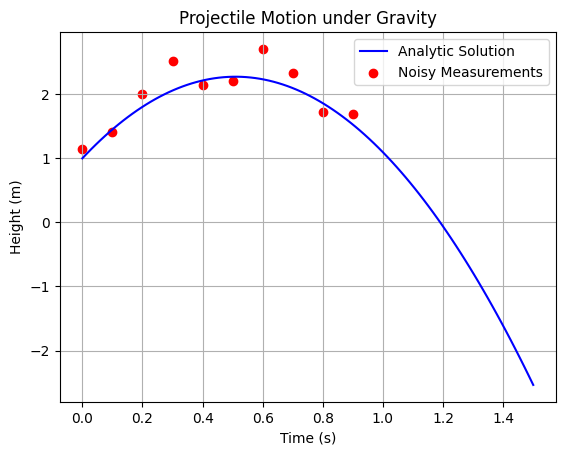

In [85]:
# Create noisy measurement data for training
num_measurements = 10
T_MEAS = 0.6*T
t_meas = np.linspace(0, T_MEAS, num_measurements)
y_meas = y_analytic(t_meas, h0, v0, g)
noise_level = 0.3  # meters. anything  >0.1 is for very noisy data
y_meas_noisy = y_meas + noise_level * np.random.randn(num_measurements)


# Convert measurement arrays to torch tensors for training (used by data loss)
t_meas_t = torch.tensor(t_meas, dtype=torch.float32, device=device).reshape(-1,1)
y_meas_t = torch.tensor(y_meas_noisy, dtype=torch.float32, device=device).reshape(-1,1)


# Plot noisy measurement data and the analytic solution for reference
t_vals = np.linspace(0, T, 100)
y_vals = y_analytic(t_vals, h0, v0, g)
plt.plot(t_vals, y_vals, label='Analytic Solution', color='blue')
plt.scatter(t_meas, y_meas_noisy, label='Noisy Measurements', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Projectile Motion under Gravity')
plt.legend()
plt.grid()
plt.show()

## Neural Network Model

In [86]:
# Simple fully-connected model mapping t -> y(t)
class Model(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=20, n_hidden=1, out_dim=1):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

# Utility: compute first and second time derivatives using autograd
def derivatives(y, t):
    # y and t are torch tensors where t.requires_grad=True
    dy = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2y = torch.autograd.grad(dy, t, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    return dy, d2y

mse = nn.MSELoss()

## Vanilla NN (data-only)

Train a standard neural network to map t -> y using only the noisy measurements (no physics constraints).

In [87]:
# Vanilla neural network trained on measurement data only
vanilla = Model(in_dim=1, hidden_dim=20, n_hidden=1, out_dim=1).to(device)
opt_v = optim.Adam(vanilla.parameters(), lr=1e-2)

# mse already defined above
n_epochs_v = 4000
print_every_v = 200
loss_v_hist = []

t_train = t_meas_t  # defined earlier from measurements
y_train = y_meas_t

for epoch in range(1, n_epochs_v+1):
    opt_v.zero_grad()
    y_pred_train = vanilla(t_train)
    loss_v = mse(y_pred_train, y_train)
    loss_v.backward()
    opt_v.step()
    loss_v_hist.append(loss_v.item())
    if epoch % print_every_v == 0 or epoch == 1:
        print(f'Vanilla Epoch {epoch:4d} | Loss: {loss_v.item():.6e}')


Vanilla Epoch    1 | Loss: 4.181262e+00
Vanilla Epoch  200 | Loss: 1.532390e-01
Vanilla Epoch  400 | Loss: 7.465843e-02
Vanilla Epoch  600 | Loss: 4.247688e-02
Vanilla Epoch  800 | Loss: 4.181434e-02
Vanilla Epoch 1000 | Loss: 4.156305e-02
Vanilla Epoch 1200 | Loss: 4.134789e-02
Vanilla Epoch 1400 | Loss: 4.114211e-02
Vanilla Epoch 1600 | Loss: 4.094579e-02
Vanilla Epoch 1800 | Loss: 4.075658e-02
Vanilla Epoch 2000 | Loss: 4.056115e-02
Vanilla Epoch 2200 | Loss: 4.032425e-02
Vanilla Epoch 2400 | Loss: 3.997589e-02
Vanilla Epoch 2600 | Loss: 3.941573e-02
Vanilla Epoch 2800 | Loss: 3.853029e-02
Vanilla Epoch 3000 | Loss: 3.723688e-02
Vanilla Epoch 3200 | Loss: 3.558634e-02
Vanilla Epoch 1600 | Loss: 4.094579e-02
Vanilla Epoch 1800 | Loss: 4.075658e-02
Vanilla Epoch 2000 | Loss: 4.056115e-02
Vanilla Epoch 2200 | Loss: 4.032425e-02
Vanilla Epoch 2400 | Loss: 3.997589e-02
Vanilla Epoch 2600 | Loss: 3.941573e-02
Vanilla Epoch 2800 | Loss: 3.853029e-02
Vanilla Epoch 3000 | Loss: 3.723688e-02


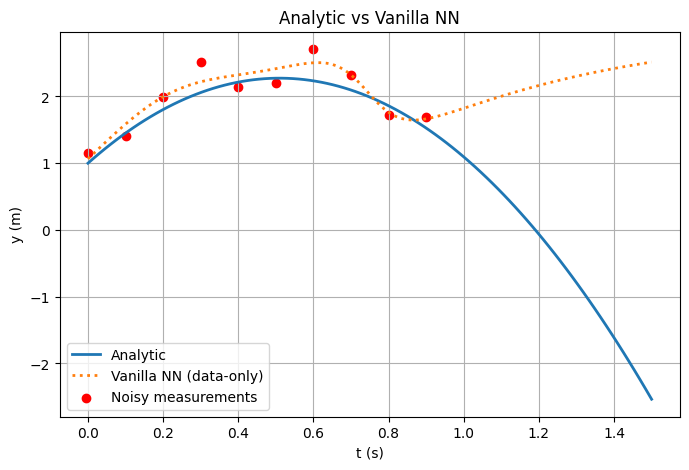

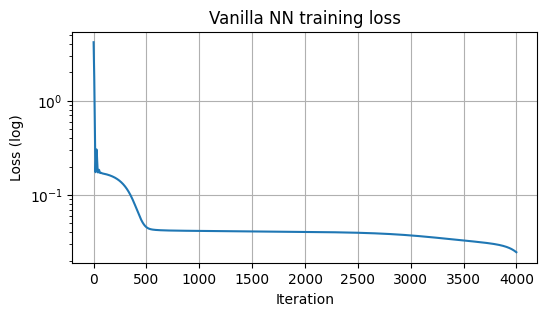

In [88]:
# Evaluate vanilla NN on test grid and compare
t_test_t = torch.tensor(t_vals, dtype=torch.float32, device=device).unsqueeze(1)
with torch.no_grad():
    y_vanilla = vanilla(t_test_t).cpu().numpy().ravel()
    
y_true = y_analytic(t_vals, h0=h0, v0=v0, g=g)

plt.figure(figsize=(8,5))
plt.plot(t_vals, y_true, label='Analytic', lw=2)
plt.plot(t_vals, y_vanilla, ':', label='Vanilla NN (data-only)', lw=2)
plt.scatter(t_meas, y_meas_noisy, label='Noisy measurements', color='red')
plt.xlabel('t (s)')
plt.ylabel('y (m)')
plt.legend()
plt.title('Analytic vs Vanilla NN')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,3))
plt.semilogy(loss_v_hist)
plt.xlabel('Iteration')
plt.ylabel('Loss (log)')
plt.title('Vanilla NN training loss')
plt.grid(True)
plt.show()


## PINN Network

In [89]:
# Prepare collocation points and initial condition tensors
N_coll = 100  # number of collocation points
t_coll = torch.linspace(0.0, T, N_coll, device=device).unsqueeze(1).float()
t_coll.requires_grad = True

# initial condition tensors (t=0)
t0 = torch.tensor([[0.0]], device=device, dtype=torch.float32, requires_grad=True)
y0_target = torch.tensor([[h0]], device=device, dtype=torch.float32)
dy0_target = torch.tensor([[v0]], device=device, dtype=torch.float32)

# Instantiate PINN (physics-informed) model, loss and optimizer
pinn = Model(in_dim=1, hidden_dim=20, n_hidden=1, out_dim=1).to(device)

optimizer = optim.Adam(pinn.parameters(), lr=1e-2)

# Training hyperparameters
n_epochs = 5000
print_every = 500

# Loss weights (easy to experiment with)
w_res = 1.0
w_ic = 1.0
w_data = 1.0

# History lists for monitoring
loss_history = []
loss_res_history = []
loss_ic_history = []
loss_data_history = []


In [90]:
# Training loop
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()

    # Predict at collocation points
    y_coll = pinn(t_coll)

    # compute derivatives
    dy_coll, d2y_coll = derivatives(y_coll, t_coll)

    # Residual: y'' + g = 0  => residual = d2y + g
    residual = d2y_coll + g
    loss_res = mse(residual, torch.zeros_like(residual))

    # Initial condition losses
    y0_pred = pinn(t0)
    dy0_pred = torch.autograd.grad(y0_pred, t0, grad_outputs=torch.ones_like(y0_pred), create_graph=True)[0]
    loss_ic = mse(y0_pred, y0_target) + mse(dy0_pred, dy0_target)

    # Data loss using noisy measurements (if any)
    try:
        y_meas_pred = pinn(t_meas_t)
        loss_data = mse(y_meas_pred, y_meas_t)
    except NameError:
        # if measurement tensors not defined, set data loss to zero
        loss_data = torch.tensor(0.0, device=device)

    # Weighted total loss
    loss = w_res * loss_res + w_ic * loss_ic + w_data * loss_data
    loss.backward()
    optimizer.step()

    # record histories
    loss_history.append(loss.item())
    loss_res_history.append(loss_res.item())
    loss_ic_history.append(loss_ic.item())
    loss_data_history.append(loss_data.item())

    if epoch % print_every == 0 or epoch == 1:
        print(f'Epoch {epoch:5d} | Loss: {loss.item():.6e} | Res: {loss_res.item():.6e} | IC: {loss_ic.item():.6e} | Data: {loss_data.item():.6e} | w_res={w_res}, w_ic={w_ic}, w_data={w_data}')

# Training finished


Epoch     1 | Loss: 1.144913e+02 | Res: 9.110666e+01 | IC: 2.092586e+01 | Data: 2.458758e+00 | w_res=1.0, w_ic=1.0, w_data=1.0
Epoch   500 | Loss: 1.470490e-01 | Res: 9.599135e-02 | IC: 6.043820e-03 | Data: 4.501382e-02 | w_res=1.0, w_ic=1.0, w_data=1.0
Epoch  1000 | Loss: 8.528018e-02 | Res: 3.488217e-02 | IC: 4.756213e-03 | Data: 4.564179e-02 | w_res=1.0, w_ic=1.0, w_data=1.0
Epoch   500 | Loss: 1.470490e-01 | Res: 9.599135e-02 | IC: 6.043820e-03 | Data: 4.501382e-02 | w_res=1.0, w_ic=1.0, w_data=1.0
Epoch  1000 | Loss: 8.528018e-02 | Res: 3.488217e-02 | IC: 4.756213e-03 | Data: 4.564179e-02 | w_res=1.0, w_ic=1.0, w_data=1.0
Epoch  1500 | Loss: 6.441303e-02 | Res: 1.400609e-02 | IC: 4.476810e-03 | Data: 4.593012e-02 | w_res=1.0, w_ic=1.0, w_data=1.0
Epoch  2000 | Loss: 5.582391e-02 | Res: 5.390634e-03 | IC: 4.355183e-03 | Data: 4.607809e-02 | w_res=1.0, w_ic=1.0, w_data=1.0
Epoch  1500 | Loss: 6.441303e-02 | Res: 1.400609e-02 | IC: 4.476810e-03 | Data: 4.593012e-02 | w_res=1.0, w_ic=

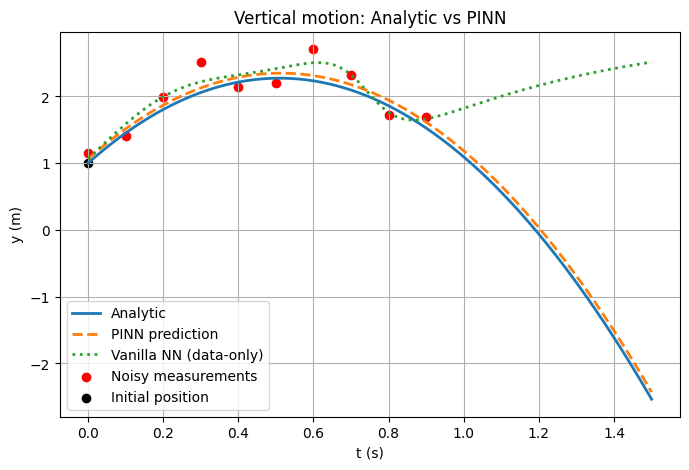

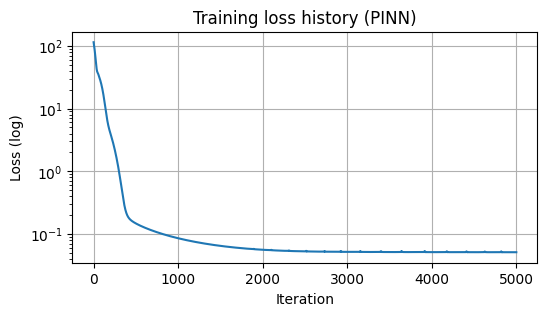

In [91]:
# Evaluate model and compare with analytic solution
t_test = np.linspace(0.0, T, 300)
t_test_t = torch.tensor(t_test, dtype=torch.float32, device=device).unsqueeze(1)
with torch.no_grad():
    y_pred = pinn(t_test_t).cpu().numpy().ravel()
    y_vanilla = vanilla(t_test_t).cpu().numpy().ravel()
y_true = y_analytic(t_test, h0=h0, v0=v0, g=g)

# Plot results
plt.figure(figsize=(8,5))
plt.plot(t_test, y_true, label='Analytic', lw=2)
plt.plot(t_test, y_pred, '--', label='PINN prediction', lw=2)
plt.plot(t_test, y_vanilla, ':', label='Vanilla NN (data-only)', lw=2)
# Show noisy measurements used for training
plt.scatter(t_meas, y_meas_noisy, label='Noisy measurements', color='red')
plt.scatter(0.0, h0, color='k', label='Initial position')
plt.xlabel('t (s)')
plt.ylabel('y (m)')
plt.legend()
plt.title('Vertical motion: Analytic vs PINN')
plt.grid(True)
plt.show()

# Optional: plot training loss
plt.figure(figsize=(6,3))
plt.semilogy(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss (log)')
plt.title('Training loss history (PINN)')
plt.grid(True)
plt.show()


## Notes and extensions

- You can increase `N_coll`, enlarge the network architecture, or train longer for higher accuracy.
- For better optimization one can use Adam followed by LBFGS, or scale/normalize inputs (e.g. divide t by T).
- This example models only the vertical motion; a 2D projectile (x and y) can be handled by a vector-valued PINN or two separate networks.